# Question 3
Identify Relationship between Building Characteristics and Top Complaint Type


##Import the PLUTO data and clean up:
- Drop null over 5% 
- Drop un-needed objects (especially with large nunique)
- Drop irrelevant building data
- Concat df and see what has the greatest p value 

# Imports + Options

In [2]:
# Normal data analysis packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 40

sns.set_style('whitegrid')

# Data

## Data Import

In [4]:
dfPLUTO_bx = pd.read_csv('BX_18v1.csv')

/Users/ianreynolds/Desktop/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dfPLUTO_bx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89854 entries, 0 to 89853
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Borough               89854 non-null  object 
 1   Block                 89854 non-null  int64  
 2   Lot                   89854 non-null  int64  
 3   CD                    89854 non-null  int64  
 4   CT2010                89447 non-null  float64
 5   CB2010                87342 non-null  float64
 6   SchoolDist            89695 non-null  float64
 7   Council               89649 non-null  float64
 8   ZipCode               89525 non-null  float64
 9   FireComp              89568 non-null  object 
 10  PolicePrct            89692 non-null  float64
 11  HealthCenterDistrict  89727 non-null  float64
 12  HealthArea            89630 non-null  float64
 13  SanitBoro             89235 non-null  float64
 14  SanitDistrict         89238 non-null  float64
 15  SanitSub           

In [6]:
df311_heat = pd.read_pickle('df311_heat.pkl')

In [7]:
df311_heat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2149424 entries, 0 to 6019841
Data columns (total 18 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   Unique Key                 int64         
 1   Created Date               object        
 2   Closed Date                object        
 3   Number of Heat Complaints  object        
 4   Location Type              object        
 5   Incident Zip               float64       
 6   Incident Address           object        
 7   Street Name                object        
 8   Address Type               object        
 9   City                       object        
 10  Status                     object        
 11  Resolution Description     object        
 12  Borough                    object        
 13  Latitude                   float64       
 14  Longitude                  float64       
 15  Created DateTime           datetime64[ns]
 16  Year                       int64    

## Data Cleaning

### Cleaning Main Complaints df

In [8]:
# Filter for Bronx borough
df311_heat_bx = df311_heat[df311_heat['Borough'] == 'BRONX']

# Drop columns that will not be needed when merged with PLUTO df
df311_heat_bx.drop([
 'Unique Key',
 'Created Date',
 'Closed Date',
 'Location Type',
 'Address Type',
 'City',
 'Status',
 'Resolution Description',
 'Borough',
 'Latitude',
 'Longitude',
 'Created DateTime',
 'Year',
 'Month'
  ], axis = 1, inplace = True)

# Create the binary result for yes/no heating complaint
df311_heat_bx.replace('HEAT/HOT WATER', 1,inplace=True)

# Drop duplicates
df311_heat_bx.drop_duplicates(subset=['Incident Address'],inplace=True)

/Users/ianreynolds/Desktop/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ianreynolds/Desktop/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/ianreynolds/Desktop/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

### Cleaning PLUTO df

In [9]:
# Drop all columns with 20% NaN threshold 
thresh = len(dfPLUTO_bx) * 0.2
dfPLUTO_bx.dropna(thresh = thresh, axis = 1, inplace = True)

# Objects that are not needed (all except for address)
# These are either covered by taking into account one borough, or have too many unique values to create dummy vars 
dfPLUTO_bx.drop([
  'Borough',
  'FireComp',
  'SanitSub',
  'ZoneDist1',
  'SplitZone',
  'BldgClass',
  'OwnerName',
  'Ext',
  'IrrLotCode',
  'ZoneMap',
  'Sanborn',
  'Version'
  ], axis = 1, inplace = True)

# Redundant info when combined with the borough or zip/street/address
dfPLUTO_bx.drop([
 'Block',
 'Lot',
 'CD',
 'CT2010',
 'CB2010',
 'SchoolDist',
 'Council',
 'PolicePrct',
 'HealthCenterDistrict',
 'HealthArea',
 'SanitBoro',
 'SanitDistrict',
 'Easements',
 'ProxCode',
 'ExemptLand',
 'ExemptTot',
 'YearAlter2',
 'BoroCode',
 'BBL',
 'CondoNo',
 'Tract2010',
 'XCoord',
 'YCoord',
 'TaxMap',
 'APPBBL',
 'PLUTOMapID'], axis = 1, inplace = True)

# Units res redundant with LandUse + UnitsTotal
# Building front and depth redundant with LotArea and BldgArea 
# LandUse and BldgArea redundant with specific areas 
# All FAR's (floor area ratio) redundant with BldgArea / LotArea
dfPLUTO_bx.drop([
 'LandUse',
 'UnitsRes',
 'LotFront',
 'LotDepth',
 'BldgFront',
 'BldgDepth',
 'AreaSource',
 'BuiltFAR',
 'ResidFAR',
 'CommFAR',
 'FacilFAR'
 ], axis = 1, inplace = True)

In [10]:
#Create dummy variable for LotType
lottype_dummies = pd.get_dummies(dfPLUTO_bx['LotType'],drop_first=True)
lottype_dummies.rename(columns = {1.0:'BlockAssemblage', 2.0:'Waterfront',3.0:'Corner', 4.0:'Through', 5.0:'Inside', 6.0:'Interior', 7.0:'Island', 8.0:'Alley', 9:'Submerged'},inplace=True)
dfPLUTO_bx = pd.concat([dfPLUTO_bx,lottype_dummies],axis=1)
dfPLUTO_bx.drop('LotType',axis=1,inplace=True)

#Create dummy variable for BsmtCode
bsmtcode_dummies = pd.get_dummies(dfPLUTO_bx['BsmtCode'],drop_first=True)
bsmtcode_dummies.rename(columns = {0.0:'NoBsmt', 1.0:'FullBsmtAbove',2.0:'FullBsmtBelow', 3.0:'PartialBsmtAbove', 4.0:'PartialBsmtBelow', 5.0:'UnknownBsmt'},inplace=True)
dfPLUTO_bx = pd.concat([dfPLUTO_bx,bsmtcode_dummies],axis=1)
dfPLUTO_bx.drop('BsmtCode',axis=1,inplace=True)

### Merging Complaint and PLUTO df and Cleaning

In [11]:
df311_final = pd.merge(left=df311_heat_bx,right=dfPLUTO_bx,how='right',left_on='Incident Address', right_on='Address')

In [12]:
df311_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89854 entries, 0 to 89853
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number of Heat Complaints  17431 non-null  float64
 1   Incident Zip               16406 non-null  float64
 2   Incident Address           17362 non-null  object 
 3   Street Name                17362 non-null  object 
 4   ZipCode                    89525 non-null  float64
 5   Address                    89785 non-null  object 
 6   LotArea                    89854 non-null  int64  
 7   BldgArea                   89854 non-null  int64  
 8   ComArea                    89854 non-null  int64  
 9   ResArea                    89854 non-null  int64  
 10  OfficeArea                 89854 non-null  int64  
 11  RetailArea                 89854 non-null  int64  
 12  GarageArea                 89854 non-null  int64  
 13  StrgeArea                  89854 non-null  int

In [13]:
if 'Number of Heat Complaints' in df311_final.columns:

    # Filling in non complaints with 0
    df311_final['Number of Heat Complaints'].fillna(0,inplace=True)
    df311_final.rename(columns = {'Number of Heat Complaints':'HeatingComplaint'},inplace=True)

    # Dropping zip and address
    df311_final.drop(['Incident Zip','ZipCode'],axis=1,inplace=True)
    df311_final.drop(['Incident Address','Address','Street Name'],axis=1,inplace=True)

    # Dropping yearbuits equal to 0
    df311_final = df311_final[df311_final['YearBuilt']!=0]

# EDA
- How balanced is the data
- Correlation

Text(0.5, 1.0, 'Balance of Heating Complaint Data')

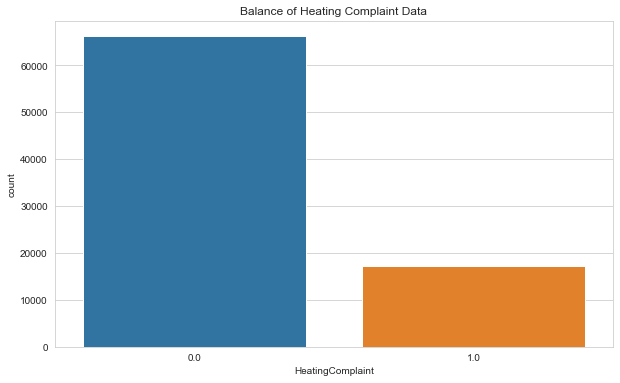

In [14]:
plt.figure(figsize=(10,6))

sns.countplot(x='HeatingComplaint', data = df311_final)
plt.title('Balance of Heating Complaint Data')

In [15]:
df311_final.corr()['HeatingComplaint'].sort_values()

FullBsmtAbove      -0.131651
YearBuilt          -0.110221
FullBsmtBelow      -0.069538
Inside             -0.065658
Waterfront         -0.024566
FactryArea         -0.018465
NumBldgs           -0.016784
StrgeArea          -0.012373
Interior           -0.006519
Alley              -0.005299
BlockAssemblage    -0.004159
PartialBsmtBelow   -0.003167
LotArea            -0.002782
PartialBsmtAbove   -0.002569
GarageArea         -0.001786
ComArea            -0.000743
OtherArea           0.000555
Through             0.001215
Island              0.001284
Submerged           0.003546
AssessLand          0.004875
OfficeArea          0.006843
RetailArea          0.008347
AssessTot           0.025084
Corner              0.074225
BldgArea            0.080461
UnitsTotal          0.089940
ResArea             0.093668
UnknownBsmt         0.123830
YearAlter1          0.129403
NumFloors           0.370900
HeatingComplaint    1.000000
Name: HeatingComplaint, dtype: float64

Text(0.5, 1, 'Correlation of Datapoints')

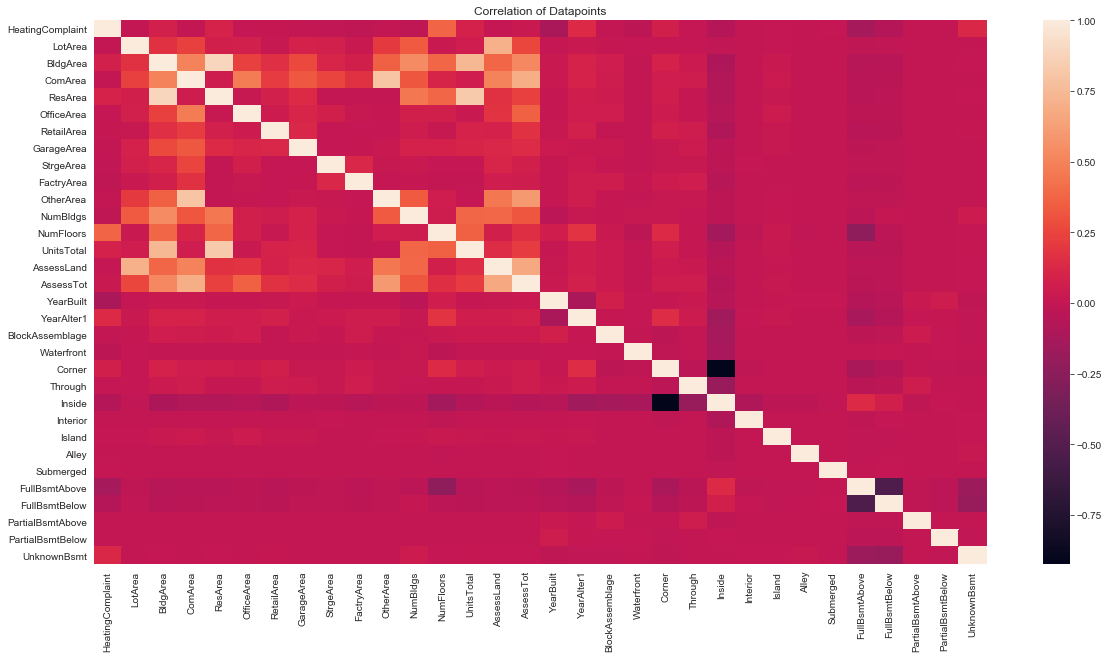

In [16]:
plt.figure(figsize=(20,10))

sns.heatmap(df311_final.corr(),annot=False)
plt.title('Correlation of Datapoints')

Text(0.5, 1.0, 'Distribution of Correlations')

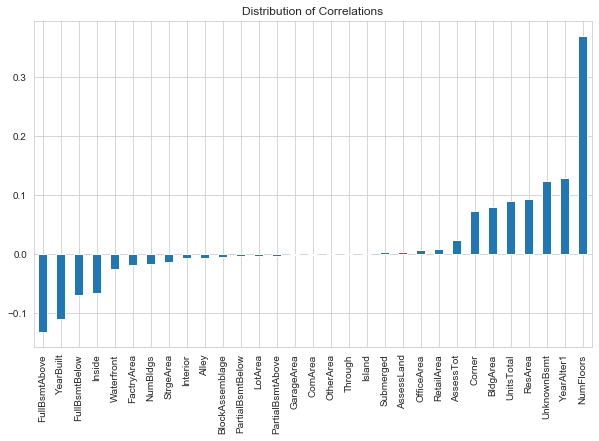

In [17]:
plt.figure(figsize=(10,6))
df311_final.corr()['HeatingComplaint'].sort_values().drop('HeatingComplaint').plot(kind='bar')
plt.title('Distribution of Correlations')

Text(0.5, 1.0, 'Count of Complaints versus Amount of Floors')

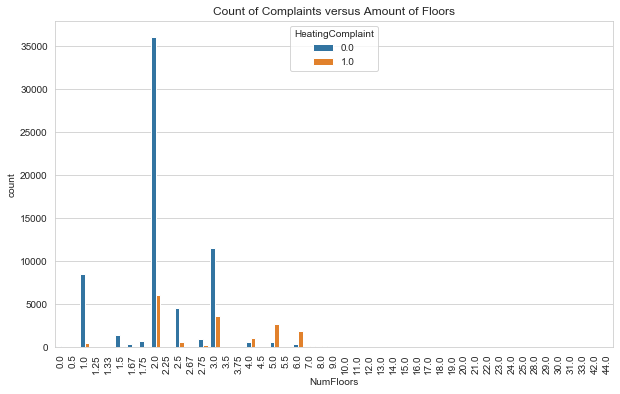

In [18]:
plt.figure(figsize=(10,6))

sns.countplot(x='NumFloors',data=df311_final,hue='HeatingComplaint')
plt.xticks(rotation=90)
plt.title('Count of Complaints versus Amount of Floors')

Text(0.5, 1.0, 'Count of Complaints versus Year Built')

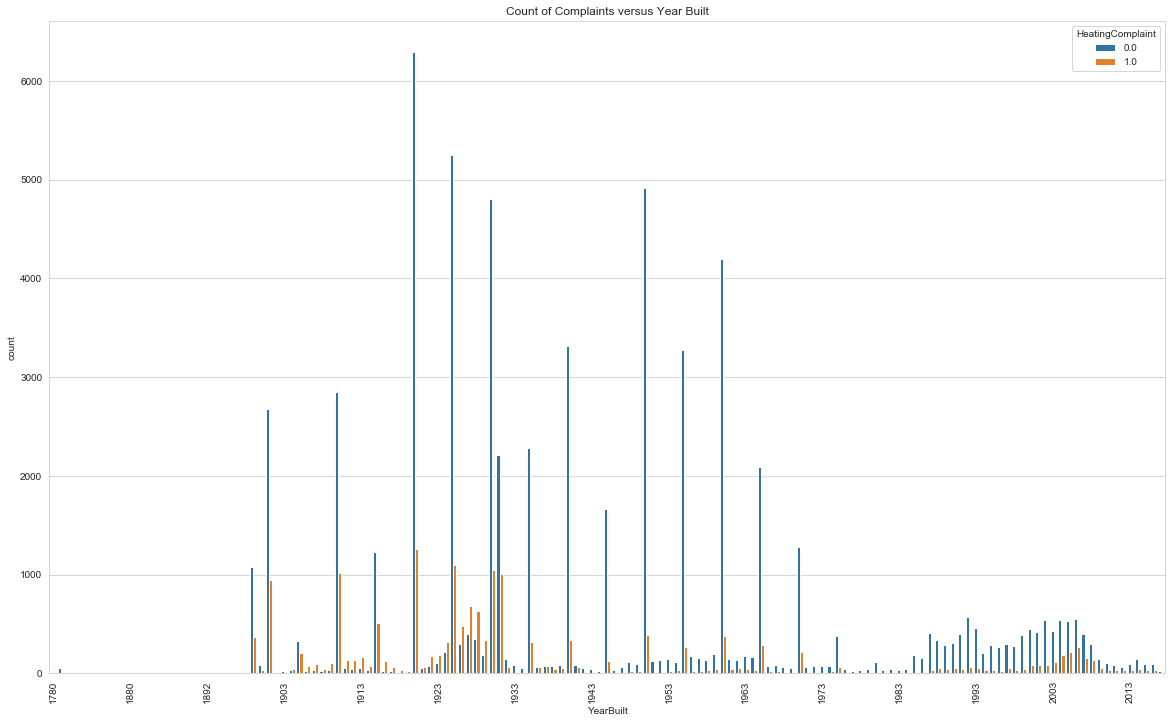

In [19]:
fig = plt.figure(figsize=(20,12))

plot_ = sns.countplot(x='YearBuilt',data=df311_final,hue='HeatingComplaint')

new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])
plt.xticks(rotation=90)
plt.title('Count of Complaints versus Year Built')

Text(0.5, 1.0, 'Count of Complaints versus Year of Alterations')

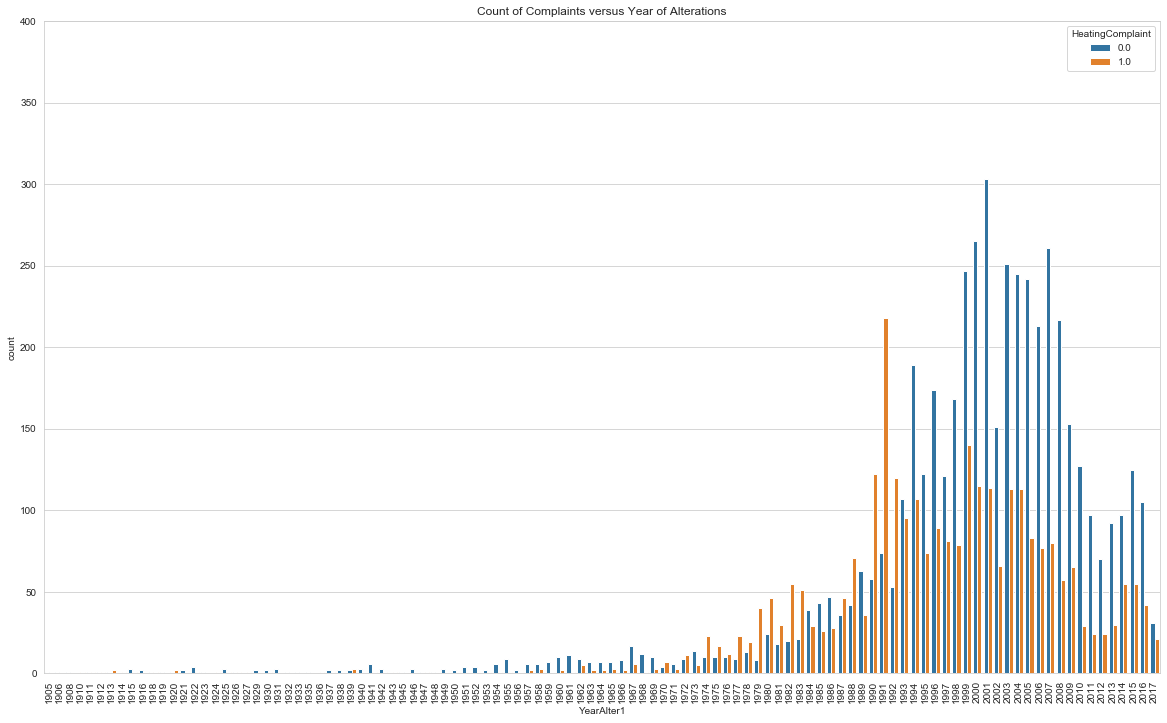

In [20]:
plt.figure(figsize=(20,12))

sns.countplot(x='YearAlter1',data=df311_final[df311_final['YearAlter1']!=0],hue='HeatingComplaint')
plt.xticks(rotation=90)
plt.ylim(0,400)
plt.title('Count of Complaints versus Year of Alterations')

# Conclusions

The top results for impact on whether a location will have heating complainats are:
- Number of floors
- Having renovations completed
- Residential area 
- Total units
- Area of the building
- If it is on a corner 
- The total cost of the building

These all make sense, as they are an indicator of the amount of tennants that would be in the building. The greater the amount of tennants, the greater the chance is that someone will have an issue at some point. 